# Cats and Dogs Convolutional Neural Network
### CST 463<br>Jose Mijangos

## Imported Modules
We will create a Convolutional Neural Network for image classification of cats and dogs. The images for training come from the CIFAR-10 data set. The number of images of cats and dogs is limited so we will alter the data to increase the diversity of the data. 

In [220]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import confusion_matrix

## Utility Functions
unpickle allows us to open the CIFAR file and access a dictionary containing the data and labels. 
<br>shuffle_batches returns a random sample from given batch data.

In [280]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx, :], y[batch_idx]
        yield X_batch, y_batch

## Load Data

The data was retrieved from Dr. Bruns Google Drive. It contains five training batches of 10000 instances, one test batch of 10000, and a ReadMe file describing the data.

In [223]:
# load training data
base_path = 'C:/Users/jose/CST_463/cifar-10-batches-py/data_batch_'
filenames = [base_path + str(i) for i in range(1, 6)]
batches = [unpickle(batch) for batch in filenames]

first_done = False
for batch in batches:
    if not first_done:
        X_train_all = batch[b'data']
        y_train_all = np.array(batch[b'labels'])
        first_done = True
    else:
        X_train_all = np.vstack((X_train_all, batch[b'data']))
        y_train_all = np.concatenate((y_train_all, batch[b'labels']))

# load test data
test_batch = unpickle('C:/Users/jose/CST_463/cifar-10-batches-py/test_batch')
X_test_all = test_batch[b'data']
y_test_all = np.array(test_batch[b'labels'])

## Select only images of Cats and Dogs
We select only the data and labels of cats and dogs.

In [325]:
# Select training data
X_train = X_train_all[(y_train_all == 3) | (y_train_all == 5)]
y_train = y_train_all[(y_train_all == 3) | (y_train_all == 5)]

# Select test data
X_test = X_test_all[(y_test_all == 3) | (y_test_all == 5)]
y_test = y_test_all[(y_test_all == 3) | (y_test_all == 5)]

## Convolutional Neural Network Structure
Here we define a layout for our convolutional neural network.

In [437]:
# Input dimensions
height = 32
width = 32
channels = 3
n_inputs = height * width * channels

# Convolutional layer
conv1_fmaps = 48
conv1_ksize = 2
conv1_stride = 1
conv1_pad = "SAME"

# Convolutional layer
conv2_fmaps = 96
conv2_ksize = 2
conv2_stride = 2
conv2_pad = "SAME"

# Convolutional layer
conv3_fmaps = 192
conv3_ksize = 2
conv3_stride = 1
conv3_pad = "SAME"

# Pooling layers
pool1_fmaps = conv1_fmaps
pool2_fmaps = conv2_fmaps
pool3_fmaps = conv3_fmaps

# Hidden layers
n_fc1 = 512
n_fc2 = 256
n_fc3 = 128
n_fc4 = 128
n_fc5 = 128

# Output layer
n_outputs = 2

## Construction Phase
Now we actually wire the convolutional neural network together.

In [450]:
tf.reset_default_graph()

# he initialization and training parameter for drop out
he_init = tf.contrib.layers.variance_scaling_initializer(mode="FAN_AVG")
training = tf.placeholder_with_default(False, shape=(), name='training')

# Data augmentation within input scope
with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels], name="X_reshaped")
    X_flip = tf.map_fn(tf.image.random_flip_left_right, X_reshaped, name="X_flip")
    X_brightness = tf.image.random_brightness(X_flip, max_delta=0.1)
    X_altered = tf.image.random_contrast(X_brightness, lower=0.95, upper=1.05)
    y = tf.placeholder(tf.int32, shape=[None], name="y")

# First layers are borrowed from geron-mnist-cnn structure
conv1 = tf.layers.conv2d(X_altered, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")

# Second layers are borrowed from geron-mnist-cnn structure
conv2 = tf.layers.conv2d(conv1, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv2")

# Extra normalization
norm1 = tf.nn.lrn(conv2, 3, bias=1.0, alpha=0.001/9.0, beta=0.75)

# Third layers are borrowed from geron-mnist-cnn structure
with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(norm1, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding="VALID")
    pool2_flat = tf.reshape(pool2, shape=[-1, pool2_fmaps * 4 * 4])

# Extra convolutional layer
conv3 = tf.layers.conv2d(pool2, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv3")

# Extra convolutional layer
conv4 = tf.layers.conv2d(conv3, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv4")

# Extra normalization
norm3 = tf.nn.lrn(conv4, 3, bias=1.0, alpha=0.001/9.0, beta=0.75)

# Extra pooling layer
with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(norm3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_flat = tf.reshape(pool4, shape=[-1, pool3_fmaps * 8 * 8])

# Extra convolutional layer
conv5 = tf.layers.conv2d(pool4, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.relu, name="conv5")

# Extra pooling layer
with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 1, 1, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool6_flat = tf.reshape(pool6, shape=[-1, pool3_fmaps * 2 * 2])

# Hidden layers
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat, n_fc1, activation=tf.nn.elu, name="fc1", kernel_initializer=he_init)
    fc1_drop = tf.layers.dropout(fc1, 0.25, training=training)
    
    fc2 = tf.layers.dense(fc1, n_fc2, activation=tf.nn.elu, name="fc2", kernel_initializer=he_init)
    fc2_drop = tf.layers.dropout(fc2, 0.25, training=training)
    
    fc3 = tf.layers.dense(fc2, n_fc3, activation=tf.nn.elu, name="fc3", kernel_initializer=he_init)
    fc3_drop = tf.layers.dropout(fc3, 0.25, training=training)
    
    fc4 = tf.layers.dense(fc3, n_fc4, activation=tf.nn.relu, name="fc4", kernel_initializer=he_init)
    fc4_drop = tf.layers.dropout(fc4, 0.25, training=training)
    
    fc5 = tf.layers.dense(fc4, n_fc5, activation=tf.nn.relu, name="fc5", kernel_initializer=he_init)
    fc5_drop = tf.layers.dropout(fc5, 0.25, training=training)

# Output layer
with tf.name_scope("output"):
    logits = tf.layers.dense(fc5, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

# Training scope
with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

# Evaluation scope
with tf.name_scope("eval"):
    predict = tf.arg_max(logits, 1)
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

# Saving scope
with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() 

## Execution Phase
Now let us see how well this convolutional neural network preforms during training.

In [451]:
# Log directory
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = ""
logdir = "{}/run-{}/".format(root_logdir, now)

# File writer
file_writer = tf.summary.FileWriter('logdir', tf.get_default_graph())
saver = tf.train.Saver()

# GPU configuration
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Training hyperparamters
n_epochs = 20
batch_size = 300

# Store accuracy 
trains = []
accs = []

# Execution
with tf.Session(config=config) as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
                
        trains.append(acc_train)
        accs.append(acc_test)
        
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
    save_path = saver.save(sess, "./CIFAR_final_model")

file_writer.close()

0 Train accuracy: 0.47854784 Test accuracy: 0.5
1 Train accuracy: 0.5511551 Test accuracy: 0.543
2 Train accuracy: 0.650165 Test accuracy: 0.6065
3 Train accuracy: 0.5874587 Test accuracy: 0.6295
4 Train accuracy: 0.6138614 Test accuracy: 0.6345
5 Train accuracy: 0.5280528 Test accuracy: 0.512
6 Train accuracy: 0.679868 Test accuracy: 0.64
7 Train accuracy: 0.6633663 Test accuracy: 0.648
8 Train accuracy: 0.68976897 Test accuracy: 0.6505
9 Train accuracy: 0.650165 Test accuracy: 0.6
10 Train accuracy: 0.70957094 Test accuracy: 0.659
11 Train accuracy: 0.7260726 Test accuracy: 0.6625
12 Train accuracy: 0.669967 Test accuracy: 0.6435
13 Train accuracy: 0.7161716 Test accuracy: 0.668
14 Train accuracy: 0.77557755 Test accuracy: 0.6765
15 Train accuracy: 0.7491749 Test accuracy: 0.651
16 Train accuracy: 0.70957094 Test accuracy: 0.6545
17 Train accuracy: 0.7458746 Test accuracy: 0.6755
18 Train accuracy: 0.7788779 Test accuracy: 0.6765
19 Train accuracy: 0.7590759 Test accuracy: 0.678


Data augmentation and drop out expedited training and overall performance so m.  

## Learning Curve

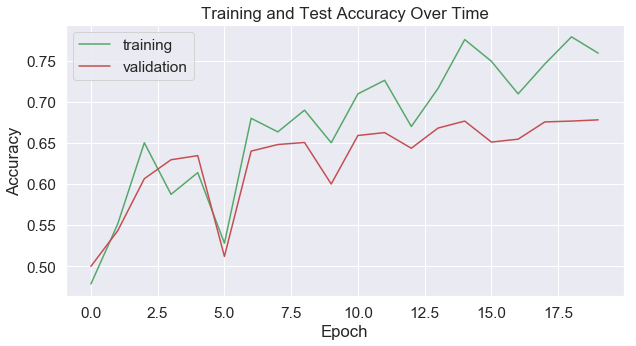

In [452]:
xs = [i for i in range(n_epochs)]
plt.figure(figsize=(10,5))
plt.plot(xs, trains, 'g', label='training')
plt.plot(xs, accs, 'r', label='validation')
plt.title('Training and Test Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

From this learning curve it appears that our nueral network begins to overfit the training data after the sixth epoch. Also, the test accuracy plateaus after the thirteenth epoch. Perhaps more regularization is needed to prevent the model from overfitting.
## Confusion Matrix

INFO:tensorflow:Restoring parameters from ./CIFAR_final_model
Accuracy 0.6735


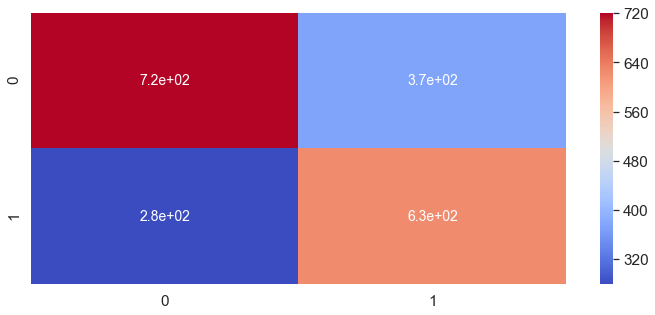

In [455]:
with tf.Session() as sess:
    saver.restore(sess, "./CIFAR_final_model")
    prediction = predict.eval(feed_dict={X: X_test, y: y_test})
    
matrix = confusion_matrix(prediction, y_test)
df_cm = pd.DataFrame(matrix, range(2), range(2))

plt.figure(figsize=(12,5))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 14}, cmap="coolwarm")

print("Accuracy", np.mean(prediction == y_test));

The accuracy of our final model is 0.6815 which is much better then the 0.5 baseline. From the confusion matrix we can see that the model has some bias towards predicting cats. We have done about eveything we can to optimize our convilutional nueral network. More data is required to further improve the performace of this model.